

# VFAE
### Implemented in TensorFlow


This notebook addresses the  topic of engineering fair(-er) data representations, devoid of bias from the sensitive features (e.g. age, sex, race).
Idea is to generate a representation of the original data, removing discriminatory associations while preserving its original quality.

- The implemented architecture is described in https://128.84.21.199/pdf/1511.00830v6.pdf
- The dataset used in this notebook is the Adult dataset, retrieved from the UCI ML repository
- The sensitive feature is given to be the age of a person

In [1]:
# HIDE
import warnings

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from IPython import display

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn import metrics

import tensorflow as tf
import tensorflow.keras as ke
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense, Dropout, concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import VarianceScaling
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, regularizers
from tensorflow.keras.layers import Input, Dense, Lambda, Layer, Add, Multiply


In [2]:
np.random.seed(7)
warnings.filterwarnings("ignore", category=FutureWarning) 
%matplotlib inline

In [3]:
print(f"numpy: {np.__version__}")
print(f"sklearn: {sk.__version__}")
print(f"pandas: {pd.__version__}")
print(f"TensorFlow: {tf.__version__}")
print(f"keras: {keras.__version__}")

numpy: 1.19.2
sklearn: 0.23.2
pandas: 1.1.3
TensorFlow: 2.4.1
keras: 2.4.0


## Column names and dtypes



In [7]:
# Columns with categorical variables
cat_columns = [
        "Workclass", "Education", "Country", "Relationship",
        "Martial Status", "Occupation", "Relationship",
        "Race", "Sex"
    ]

# All columns
columns = ["Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status", \
              "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
                "Hours per week", "Country", "Target"]

# Data types
types = {0: int, 1: str, 2: int, 3: str, 4: int, 5: str, 6: str, 7: str, 8: str, 9: str, 10: int,
                                11: int, 12: int, 13: str, 14: str}


## Implementing the P-rule
From (Biddle, 2005), lets us verify proportionality in outcomes per sensitive feature value

In [8]:

def p_rule(y_pred, x_sensitive, threshold=0.5):
    y_z_1 = y_pred[x_sensitive == 1] > threshold if threshold else y_pred[x_sensitive == 1]
    y_z_0 = y_pred[x_sensitive == 0] > threshold if threshold else y_pred[x_sensitive == 0]
    odds = y_z_1.mean() / y_z_0.mean()
    return np.min([odds, 1/odds]) * 100


## Pre-processing functions for Adult dataset
- Source of data : https://archive.ics.uci.edu/ml/datasets/adult

In [9]:
# remove observations with missing feature values
def remove_missing(X):
    m = X.shape[0]
    print('Raw Dataset size : ', m)
    X.replace('nan', np.nan, inplace=True)
    X.dropna(inplace=True)
    n = X.shape[0]
    print('Size after dropping null values: ', n)
    print('Removed ', (m-n), ' observations')

    
# one-hot encode categorical data
def replace_categorical(X):
    X_sets = [X.select_dtypes(include=[i]).copy() for i in ['object', 'int']]
    X_cat , X_n = X_sets
    [print(n, ' set size:' , i.shape) 
     for (n,i) in zip(['\nCategorical',
                       'Continuous'],
                          X_sets)]
    
    X_cat = pd.get_dummies(X_cat, columns=cat_columns)
    return pd.concat([X_n, X_cat], axis=1)


# Split features and labels
def separate_label(X):
    y = X['Target'].copy()
    X = X.drop(['Target'], axis=1)
    y = LabelEncoder().fit_transform(y)
    return X, y


# Binarize continuous features with column mean
def binarize_features(X):
    for i in range(6):
        thresh = X.iloc[:, i].mean()
        X.iloc[:, i] = np.where(X.iloc[:, i].values > thresh, 1,0)
    return X


# Load and preprocess
def load_adult(binarize=False):
    data = pd.read_csv(
        "./VFIB/data/adult/adult.csv",
        names=columns,
        sep=r'\s*,\s*',
        engine='python', skiprows=1,
        na_values="?",
        dtype=types)
    
    remove_missing(data)
    X, y = separate_label(data)
    X = replace_categorical(data)
    
    if binarize:
        binarize_features(X)

    return train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)



## Load Adult Dataset
- `binarize` flag to binarize continuous features
- Otherwise scaling required

In [10]:
data = load_adult(binarize=True)

X_train, X_test, y_train, y_test = [i.astype(np.float32) for i in data]

Raw Dataset size :  48842
Size after dropping null values:  45222
Removed  3620  observations

Categorical  set size: (45222, 9)
Continuous  set size: (45222, 6)


## Examine data

In [8]:
_ = [print(i.shape) for i in data]

(31655, 110)
(13567, 110)
(31655,)
(13567,)


In [9]:
X_train.head(3)

,Age,fnlwgt,Education-Num,Capital Gain,Capital Loss,Hours per week,Workclass_Federal-gov,Workclass_Local-gov,Workclass_Private,Workclass_Self-emp-inc,...,Relationship_Own-child,Relationship_Unmarried,Relationship_Wife,Race_Amer-Indian-Eskimo,Race_Asian-Pac-Islander,Race_Black,Race_Other,Race_White,Sex_Female,Sex_Male
27314,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
31381,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
30713,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


## Define Encoder Layer
- Variational encoder, with 3 outputs: 
mean (`mu`), log_variance (`sigma`) and latent representation (`z`)  
- `Sampling` class used to reparametrize latent representation `z` 

In [10]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding of an observation."""

    def call(self, inputs):
        z_mu, z_log_sigma = inputs
        batch = tf.shape(z_mu)[0]
        dim = tf.shape(z_mu)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mu + tf.exp(0.5 * z_log_sigma) * epsilon


class Encoder(keras.layers.Layer):
    def __init__(self, input_dim, latent_dim, act):
        super(Encoder, self).__init__()
        self.dense_1 = Dense(input_dim*2, activation=act, input_shape=(input_dim,))
        self.dense_2 = Dense(input_dim/4, activation=act)
        self.z_mean =  Dense(latent_dim, name='mu')
        self.z_log_sigma = Dense(latent_dim, name='log_sigma')
        
        
    def call(self, x):        
        x = self.dense_1(x)
        x = self.dense_2(x)
        
        mean = self.z_mean(x)
        log_sigma = self.z_log_sigma(x)
        z = Sampling()([mean, log_sigma])
        
        return mean, log_sigma, z

## Examine Encoder output
- Each layer has an output shape of `n x l`, where `n` is number of observations and `l` is size of latent representation

In [11]:
input_dim = X_train.shape[-1]
latent_dim = 2

In [12]:
output_encoder = Encoder(input_dim, latent_dim, 'relu')(X_train.values)
mu, sigma, z = output_encoder

In [13]:
_ = [print(n, 'output shape :', i.shape) for n,i in zip(['mu', 'sigma', 'z'],output_encoder)]

mu output shape : (31655, 2)
sigma output shape : (31655, 2)
z output shape : (31655, 2)


### Define Decoder

In [14]:
class Decoder(keras.layers.Layer):
    def __init__(self, latent_dim, act):
        super(Decoder, self).__init__()
        self.dense_1 = Dense(input_dim/4, activation=act, input_shape=(latent_dim,))
        self.dense_2 = Dense(input_dim*2, activation=act)
        self.output_layer = Dense(input_dim)
        
    def call(self, x):
        x = self.dense_1(x)
        x = self.dense_2(x)
        return self.output_layer(x)



### Examine reconstructed output
- `n x f`, where n is number of training observations and f is number of features per observation

In [15]:
X_train.shape

(31655, 110)

In [16]:
reconstruction = Decoder(latent_dim, 'relu')(z).numpy()
reconstruction.shape


(31655, 110)

### Define Classifier

In [17]:
class Classifier(keras.layers.Layer):
    def __init__(self, latent_dim, act, n_sens = 0):
        super(Classifier, self).__init__()
        self.dense_1 = Dense(64, activation=act, input_shape=(latent_dim+n_sens,))
        self.dense_2 = Dense(32, activation=act)
        self.dropout =  Dropout(0.2)
        self.output_layer = Dense(1)
        
    def call(self, x):
        x = self.dense_1(x)
        x = self.dropout(x)
        x = self.dense_2(x)
        x = self.dropout(x)
        return self.output_layer(x)

### Examine classifier output
- `n x 1`, where n is number of training observations

In [18]:
sensitive_attr = X_train.Age.values.reshape(-1,1)
n_sens = 1
output_predictor = Classifier(latent_dim, 'relu', n_sens=1)(tf.concat([mu, sensitive_attr], axis=1))
output_predictor

<tf.Tensor: shape=(31655, 1), dtype=float32, numpy=
array([[ 0.24444401],
       [ 0.27762982],
       [ 0.02405109],
       ...,
       [ 0.00250461],
       [-0.00986578],
       [ 0.00408537]], dtype=float32)>

### Define VFAE model
- Implemented with 3 different losses:
    * `Negative log bernoulli` for classification
    * `Kullback Leiber Divergence` constrains latent distribution to original data distribution
    * `Maximum mean discrepency` forces model to match moments between marginal posterior distributions of latent variables w.r.t sensitive attribute values; i.e., qφ(z|s = 0) and qφ(z|s = 1)
    


In [52]:
class VFAE(keras.Model):
    def __init__(self,
                 encoder,
                 encoder_z,
                 reconstructor_z,
                 decoder,
                 classifier,
                 feature_dim,
                 loss_type,
                 **kwargs):
        
        super(VFAE, self).__init__(**kwargs)
        
        self.eps = tf.constant([10e-25])
        self.beta=1.
        
        self.encoder = encoder
        self.encoder_z = encoder_z
        self.reconstructor_z = reconstructor_z
        self.decoder = decoder
        self.classifier = classifier
        
        self.loss_type = loss_type
        
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.prediction_loss_tracker = keras.metrics.Mean(name="pred_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.mmd_loss_tracker = keras.metrics.Mean(name="mmd_loss")
        self.reconst_loss_tracker = keras.metrics.Mean(name="reconst_loss")
        self.reconst_z_loss_tracker = keras.metrics.Mean(name="reconst_z_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.prediction_loss_tracker,
            self.kl_loss_tracker,
            self.mmd_loss_tracker,
            self.reconst_loss_tracker,
            self.reconst_z_loss_tracker
        ]
    
    
    @tf.function
    def entropy_gaussian(self, mu, sigma, mean=True):
        msigma = tf.reshape(sigma, (K.shape(sigma)[0], -1))
        return tf.reduce_mean(0.5*msigma)
    
    @tf.function
    def negative_log_gaussian(self, data, mu, sigma, mean=True):
        mdata = tf.reshape(data, (K.shape(data)[0], -1))
        mmu = tf.reshape(mu, (K.shape(data)[0], -1))
        msigma = tf.reshape(sigma, (K.shape(data)[0], -1))

        return 0.5 * tf.reduce_mean((mdata-mmu)**2/(K.exp(msigma)+self.eps) + msigma)
    
    @tf.function
    def neg_log_bernoulli(self, true, pred, mean=True, clamp=True, rec=False):
        if clamp:
            pred = K.clip(pred, -9.5, 9.5)
           
        batch_size = K.shape(true)[0]
        dim = 1 if not rec else 110

        mdata = tf.reshape( true, (batch_size,dim) )
        mmu = tf.reshape( pred, (batch_size,dim) )

        log_prob_1 = tf.math.log_sigmoid(mmu)
        log_prob_2 = tf.math.log_sigmoid(-mmu)
        return -tf.reduce_mean((mdata*log_prob_1)+(1-mdata)*log_prob_2)
    
    @tf.function
    def KL(self, mu, log_sigma):
        kl_loss = 0.5 * tf.reduce_mean(( - log_sigma + K.square(mu) + K.exp(log_sigma)))
        return kl_loss
    

    @tf.function
    def mmd_loss(self, X, z):
        
        def md(t, l):
            s_0 = tf.where(t[:,0]==0)
            s_1 =tf.where(t[:,0]==1)

            z_0 = tf.gather(l, s_0)
            z_1 = tf.gather(l, s_1)

            z_0 = tf.reshape(z_0, (K.shape(z_0)[0], K.shape(z_0)[-1]))
            z_1 = tf.reshape(z_1, (K.shape(z_1)[0], K.shape(z_1)[-1]))
            return z_0, z_1
        
        def kernel(a,b):
            dist1 = tf.expand_dims(tf.math.reduce_sum((a**2), axis=1), axis=1) * tf.ones(shape=(1,K.shape(b)[0]))
            dist2 = tf.expand_dims(tf.math.reduce_sum((b**2), axis=1), axis=0)* tf.ones(shape=(K.shape(a)[0], 1))
            dist3 = tf.matmul(a, tf.transpose(b, perm=[1, 0]))
            dist = (dist1 + dist2) - (2 * dist3)
            return tf.reduce_mean(tf.math.exp(-dist))
        
        z_s_0, z_s_1 = md(X, z)
        loss = kernel(z_s_0, z_s_0) + kernel(z_s_1, z_s_1) - 2 * kernel(z_s_0, z_s_1)
        return loss
    
    def split_sensitive_X(self, tensor, col, n):
        '''takes Xn (2D feature tensor) and returns 2 tensors(sensitive features and normal features)'''
        dim = tensor.shape[-1]
        pre, sens, post =  tf.split(tensor, (col, n, (dim-(col+n))), axis=1)
        return sens, tf.concat([pre, post], axis=1)
    

    
    def call(self, inputs):
        X, y = inputs
        
        sens, _ = self.split_sensitive_X(X, 0, 1)
        
        y = tf.reshape(y, (-1,1))

        z_mean, z_log_sigma, z = self.encoder(X)
        
        q_z_1_mean, q_z_1_log_sigma, z_1 = self.encoder_z(tf.concat([z,y], axis=1))
        
        reconst = self.decoder(tf.concat([z, sens], axis=1))
        
        z_reconst_mean, z_reconst_log_sigma, _ = self.reconstructor_z(tf.concat([z_1, y], axis=1))

        preds = self.classifier(z)

        
        return z_mean, z_log_sigma, z,                      \
                reconst, q_z_1_mean, q_z_1_log_sigma, z_1,   \
                z_reconst_mean, z_reconst_log_sigma, preds
    
                
        
        
    def train_step(self, data):
        X, y = data
        with tf.GradientTape() as tape:
            
            z_mean, z_log_sigma, z,                                       \
            reconst, q_z_1_mean, q_z_1_log_sigma, z_1,                    \
            z_reconst_mean, z_reconst_log_sigma, preds = self.call(data)
            
    
            reconst_loss = self.neg_log_bernoulli(X, reconst, rec=1)
        
            reconst_z_loss = self.negative_log_gaussian(z, z_reconst_mean, z_reconst_log_sigma)
            
            classifier_loss = self.neg_log_bernoulli(y, preds)
            
            kl_loss = self.KL(q_z_1_mean, q_z_1_log_sigma)
            
            mmd_loss = self.mmd_loss(X, z)
            
            entropy_z = self.entropy_gaussian(z_mean, z_log_sigma)
            
            total_loss = reconst_loss + kl_loss + reconst_z_loss - entropy_z + self.beta*classifier_loss

                

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.prediction_loss_tracker.update_state(classifier_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.mmd_loss_tracker.update_state(mmd_loss)
        self.reconst_loss_tracker.update_state(reconst_loss)
        self.reconst_z_loss_tracker.update_state(reconst_z_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "classification_loss": self.prediction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "mmd_loss": self.mmd_loss_tracker.result(),
            "reconst_loss": self.reconst_loss_tracker.result(),
            "reconst_z_loss": self.reconst_z_loss_tracker.result()
        }


In [53]:
X_train.shape


(31655, 110)

### Training loop

- We train the model for 100 epochs, 10 times, for each loss typeompare model performance with different losses
    * `NLB` + `KLD` + `MMD`
    * `NLB` + `KLD`
    * `NLB`
- Accuracy of models evaluated using `roc` and `accuracy` score
- Fairness evaluated using `p-rule`

In [54]:
def training_period(epochs, bs):
  
    model = VFAE(encoding_module,
                 z_encoding_module,
                 reconstruction_module,
                 decoding_module,
                 prediction_module,
                 input_dim, loss_type)
    
    model.compile(optimizer=opt)
    model.fit(X_train, y_train, batch_size=bs, epochs=epochs)


In [55]:

latent_dim=50
act = 'tanh'
opt = tf.keras.optimizers.Adam(lr=0.002)
epochs = 100
batch_size = 128
training_periods = 5
loss_type=0

In [56]:
encoding_module = Encoder(input_dim, latent_dim, act)
z_encoding_module = Encoder(latent_dim+1, latent_dim, act)
reconstruction_module = Encoder(latent_dim+1, latent_dim, act)
decoding_module = Decoder(latent_dim+1, act)
prediction_module = Classifier(latent_dim, act)

In [57]:
training_period(300, 128)

Epoch 1/300
248/248 [==============================] - 11s 11ms/step - loss: 1.8139 - classification_loss: 0.4319 - kl_loss: 0.5148 - mmd_loss: 0.0321 - reconst_loss: 0.1987 - reconst_z_loss: 0.4957
Epoch 2/300
248/248 [==============================] - 3s 11ms/step - loss: 1.5589 - classification_loss: 0.3604 - kl_loss: 0.5186 - mmd_loss: 0.0320 - reconst_loss: 0.1596 - reconst_z_loss: 0.4368
Epoch 3/300
248/248 [==============================] - 3s 11ms/step - loss: 1.5418 - classification_loss: 0.3518 - kl_loss: 0.5231 - mmd_loss: 0.0320 - reconst_loss: 0.1547 - reconst_z_loss: 0.4270
Epoch 4/300
248/248 [==============================] - 3s 11ms/step - loss: 1.5398 - classification_loss: 0.3544 - kl_loss: 0.5240 - mmd_loss: 0.0320 - reconst_loss: 0.1496 - reconst_z_loss: 0.4330
Epoch 5/300
248/248 [==============================] - 3s 11ms/step - loss: 1.5282 - classification_loss: 0.3441 - kl_loss: 0.5238 - mmd_loss: 0.0320 - reconst_loss: 0.1457 - reconst_z_loss: 0.4420
Epoch 6/3

248/248 [==============================] - 3s 12ms/step - loss: 1.4995 - classification_loss: 0.3299 - kl_loss: 0.5271 - mmd_loss: 0.0320 - reconst_loss: 0.1175 - reconst_z_loss: 0.6322 0s - loss: 1.4973 - classification_loss: 0.3279 - kl_loss: 0.5271 - mmd_loss: 0.0316 - reconst_los
Epoch 43/300
248/248 [==============================] - 3s 11ms/step - loss: 1.5054 - classification_loss: 0.3359 - kl_loss: 0.5272 - mmd_loss: 0.0320 - reconst_loss: 0.1175 - reconst_z_loss: 0.6313
Epoch 44/300
248/248 [==============================] - 3s 11ms/step - loss: 1.4971 - classification_loss: 0.3278 - kl_loss: 0.5274 - mmd_loss: 0.0320 - reconst_loss: 0.1171 - reconst_z_loss: 0.6316
Epoch 45/300
248/248 [==============================] - 3s 11ms/step - loss: 1.4936 - classification_loss: 0.3240 - kl_loss: 0.5275 - mmd_loss: 0.0319 - reconst_loss: 0.1168 - reconst_z_loss: 0.6361
Epoch 46/300
248/248 [==============================] - 3s 11ms/step - loss: 1.4989 - classification_loss: 0.3293 - kl

248/248 [==============================] - 3s 12ms/step - loss: 1.4745 - classification_loss: 0.3039 - kl_loss: 0.5261 - mmd_loss: 0.0320 - reconst_loss: 0.1154 - reconst_z_loss: 0.7136
Epoch 83/300
248/248 [==============================] - 3s 11ms/step - loss: 1.4690 - classification_loss: 0.2991 - kl_loss: 0.5260 - mmd_loss: 0.0319 - reconst_loss: 0.1157 - reconst_z_loss: 0.7078
Epoch 84/300
248/248 [==============================] - 3s 11ms/step - loss: 1.4682 - classification_loss: 0.2992 - kl_loss: 0.5259 - mmd_loss: 0.0320 - reconst_loss: 0.1157 - reconst_z_loss: 0.7108
Epoch 85/300
248/248 [==============================] - 3s 12ms/step - loss: 1.4715 - classification_loss: 0.3007 - kl_loss: 0.5261 - mmd_loss: 0.0320 - reconst_loss: 0.1157 - reconst_z_loss: 0.7101
Epoch 86/300
248/248 [==============================] - 3s 11ms/step - loss: 1.4644 - classification_loss: 0.2941 - kl_loss: 0.5259 - mmd_loss: 0.0320 - reconst_loss: 0.1158 - reconst_z_loss: 0.7105
Epoch 87/300
248/2

248/248 [==============================] - 3s 11ms/step - loss: 1.4364 - classification_loss: 0.2645 - kl_loss: 0.5252 - mmd_loss: 0.0320 - reconst_loss: 0.1159 - reconst_z_loss: 0.6935
Epoch 124/300
248/248 [==============================] - 3s 12ms/step - loss: 1.4375 - classification_loss: 0.2660 - kl_loss: 0.5250 - mmd_loss: 0.0320 - reconst_loss: 0.1161 - reconst_z_loss: 0.6953
Epoch 125/300
248/248 [==============================] - 3s 11ms/step - loss: 1.4352 - classification_loss: 0.2622 - kl_loss: 0.5250 - mmd_loss: 0.0320 - reconst_loss: 0.1160 - reconst_z_loss: 0.6966
Epoch 126/300
248/248 [==============================] - 3s 11ms/step - loss: 1.4357 - classification_loss: 0.2631 - kl_loss: 0.5251 - mmd_loss: 0.0320 - reconst_loss: 0.1161 - reconst_z_loss: 0.6941
Epoch 127/300
248/248 [==============================] - 3s 11ms/step - loss: 1.4371 - classification_loss: 0.2658 - kl_loss: 0.5252 - mmd_loss: 0.0320 - reconst_loss: 0.1161 - reconst_z_loss: 0.6934
Epoch 128/300


248/248 [==============================] - 3s 11ms/step - loss: 1.4161 - classification_loss: 0.2453 - kl_loss: 0.5262 - mmd_loss: 0.0320 - reconst_loss: 0.1157 - reconst_z_loss: 0.6939
Epoch 164/300
248/248 [==============================] - 3s 11ms/step - loss: 1.4170 - classification_loss: 0.2444 - kl_loss: 0.5262 - mmd_loss: 0.0320 - reconst_loss: 0.1158 - reconst_z_loss: 0.6965
Epoch 165/300
248/248 [==============================] - 3s 11ms/step - loss: 1.4101 - classification_loss: 0.2388 - kl_loss: 0.5261 - mmd_loss: 0.0319 - reconst_loss: 0.1157 - reconst_z_loss: 0.6943
Epoch 166/300
248/248 [==============================] - 3s 11ms/step - loss: 1.4182 - classification_loss: 0.2460 - kl_loss: 0.5264 - mmd_loss: 0.0320 - reconst_loss: 0.1158 - reconst_z_loss: 0.6914
Epoch 167/300
248/248 [==============================] - 3s 11ms/step - loss: 1.4138 - classification_loss: 0.2414 - kl_loss: 0.5265 - mmd_loss: 0.0319 - reconst_loss: 0.1155 - reconst_z_loss: 0.6921
Epoch 168/300


248/248 [==============================] - 3s 11ms/step - loss: 1.3973 - classification_loss: 0.2252 - kl_loss: 0.5273 - mmd_loss: 0.0320 - reconst_loss: 0.1160 - reconst_z_loss: 0.7043
Epoch 204/300
248/248 [==============================] - 3s 11ms/step - loss: 1.4058 - classification_loss: 0.2350 - kl_loss: 0.5273 - mmd_loss: 0.0320 - reconst_loss: 0.1158 - reconst_z_loss: 0.7085
Epoch 205/300
248/248 [==============================] - 3s 11ms/step - loss: 1.3992 - classification_loss: 0.2279 - kl_loss: 0.5274 - mmd_loss: 0.0320 - reconst_loss: 0.1158 - reconst_z_loss: 0.7099
Epoch 206/300
248/248 [==============================] - 3s 11ms/step - loss: 1.4057 - classification_loss: 0.2350 - kl_loss: 0.5270 - mmd_loss: 0.0319 - reconst_loss: 0.1161 - reconst_z_loss: 0.7151
Epoch 207/300
248/248 [==============================] - 3s 11ms/step - loss: 1.4029 - classification_loss: 0.2301 - kl_loss: 0.5274 - mmd_loss: 0.0320 - reconst_loss: 0.1160 - reconst_z_loss: 0.7184
Epoch 208/300


248/248 [==============================] - 3s 11ms/step - loss: 1.3880 - classification_loss: 0.2166 - kl_loss: 0.5269 - mmd_loss: 0.0320 - reconst_loss: 0.1161 - reconst_z_loss: 0.7522
Epoch 245/300
248/248 [==============================] - 3s 11ms/step - loss: 1.3920 - classification_loss: 0.2203 - kl_loss: 0.5268 - mmd_loss: 0.0320 - reconst_loss: 0.1162 - reconst_z_loss: 0.7521
Epoch 246/300
248/248 [==============================] - 3s 11ms/step - loss: 1.3978 - classification_loss: 0.2268 - kl_loss: 0.5268 - mmd_loss: 0.0319 - reconst_loss: 0.1160 - reconst_z_loss: 0.7516
Epoch 247/300
248/248 [==============================] - 3s 11ms/step - loss: 1.3952 - classification_loss: 0.2238 - kl_loss: 0.5269 - mmd_loss: 0.0320 - reconst_loss: 0.1160 - reconst_z_loss: 0.7523
Epoch 248/300
248/248 [==============================] - 3s 11ms/step - loss: 1.3968 - classification_loss: 0.2246 - kl_loss: 0.5271 - mmd_loss: 0.0320 - reconst_loss: 0.1160 - reconst_z_loss: 0.7514
Epoch 249/300


248/248 [==============================] - 3s 11ms/step - loss: 1.3848 - classification_loss: 0.2147 - kl_loss: 0.5263 - mmd_loss: 0.0320 - reconst_loss: 0.1161 - reconst_z_loss: 0.7869
Epoch 286/300
248/248 [==============================] - 3s 11ms/step - loss: 1.3898 - classification_loss: 0.2189 - kl_loss: 0.5264 - mmd_loss: 0.0319 - reconst_loss: 0.1160 - reconst_z_loss: 0.7874
Epoch 287/300
248/248 [==============================] - 3s 11ms/step - loss: 1.3837 - classification_loss: 0.2118 - kl_loss: 0.5263 - mmd_loss: 0.0319 - reconst_loss: 0.1161 - reconst_z_loss: 0.7911
Epoch 288/300
248/248 [==============================] - 3s 11ms/step - loss: 1.3836 - classification_loss: 0.2131 - kl_loss: 0.5265 - mmd_loss: 0.0320 - reconst_loss: 0.1161 - reconst_z_loss: 0.7895
Epoch 289/300
248/248 [==============================] - 3s 11ms/step - loss: 1.3897 - classification_loss: 0.2191 - kl_loss: 0.5267 - mmd_loss: 0.0320 - reconst_loss: 0.1160 - reconst_z_loss: 0.7916
Epoch 290/300


In [58]:

zm, zls, z = encoding_module(X_train.values)






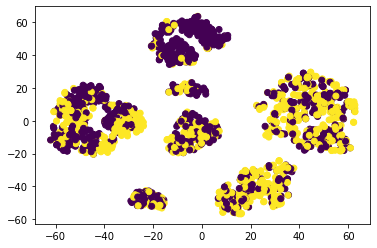

In [48]:
t = TSNE(n_components=2)
r = t.fit_transform(X_train.values[:2000,1:])

plt.scatter(r[:,0], r[:,1], c= X_train.values[:2000,0])

In [61]:
r = t.fit_transform(z)

27314    1.0
31381    1.0
30713    0.0
40890    0.0
12278    0.0
        ... 
12678    1.0
20565    1.0
36104    0.0
12376    0.0
44310    0.0
Name: Age, Length: 31655, dtype: float32

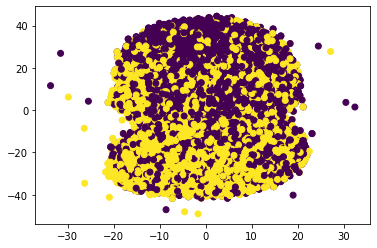

In [64]:

plt.scatter(r[:,0], r[:,1], c= X_train.iloc[:,0])

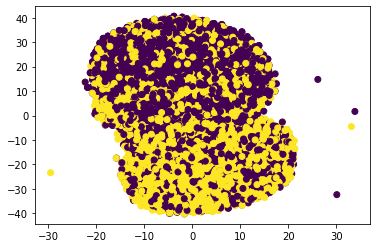

In [50]:
r = t.fit_transform(z)
plt.scatter(r[:,0], r[:,1], c= X_train.values[:,0])

### Examining results

Examining the predictions from VFIB using the `p-rule`, we observe that the model converges to more fair latent representations when using all three losses (`NLB`, `KLD`, and `MMD`), while mantaining an `roc` score above 86%

- We see that the p-rule gives a value of 35.4% when model is trained with all losses, 34.3% when trained with `NLB` and `KL`, and finally 32.5% when only trained with `NLB`.

- We note that model accuracy suffers slightly as we add the MMD and KL constraints to the prediction loss


In [177]:
for loss_type in list(losses.keys()):
    print('With loss : %s'%loss_type)
    for r in list(res.keys()):
        print(r, np.mean(losses[loss_type][r]))
    print()


With loss : all
roc 0.8871750180199427
acc 0.8322399941033389
p-rule 30.55407456569417



### Note on statistical parity in test data
Using the p-rule to plot true target distributions w.r.t the sensitive attribute `age`, we obtain a p-ratio of `~42%`, to which the VFIB comes close `(35.4%)`

In [158]:
# Train Data
p_rule(y_train, X_train.values[:,0])

41.969948364324

In [159]:
# Test Data
p_rule(y_test, X_test.values[:,0])

42.746847811319334